In [1]:
import gym
import gym_anytrading
import os

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

2023-08-19 19:24:44.273631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 19:24:46.127415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def genreate_stock_data(stock_name,period):
    company = yf.Ticker(stock_name)
    df = company.history(period=period)
    
    #Sepreate the dates of the stock for further use if required
    date = (df.reset_index())['Date']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove data object from the database
    df = (df.reset_index()).drop('Date',axis=1)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the current trend of the current stock
    t = []
    for i in range(len(df)):
        if(df['Open'].iloc[i]-df['Close'].iloc[i]>0):
            t.append("DOWN")
        else:
            t.append("UP")
            
    df['Trend']=t
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the trend history of the stock
    th=[0]
    current_trend = df['Trend'].iloc[0]
    count = 0
    for i in range(1,len(df)):
        if(current_trend==df['Trend'].iloc[i]):
            count+=1
            th.append(count)
        else:
            count = 0
            th.append(count)
            current_trend = df['Trend'].iloc[i]
            
    df["Trend history"]=th
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the comparison to the change since last peak
    p=[]
    v=[]
    if(df['Trend'].iloc[0]=="DOWN"):
        peak = df['Open'].iloc[0]
        valley = df['Close'].iloc[0]
    else:
        valley = df['Open'].iloc[0]
        peak = df['Close'].iloc[0]

    for i in range(0,len(df)):

        p.append(peak-df['Close'].iloc[i])
        v.append(valley-df['Close'].iloc[i])

        if peak<df['Close'].iloc[i]:
            peak = df['Close'].iloc[i]
        if valley>df['Close'].iloc[i]:
            valley = df['Close'].iloc[i]
            
    df['Change since last peak']=p
    df['Change since last drop']=v
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the local change of daily stock
    c=[]
    cm=[]
    for i in range(0,len(df)):
        c.append(df['Open'].iloc[i]-df['Close'].iloc[i])
        cm.append(df['High'].iloc[i]-df['Low'].iloc[i])

    df['Local Change']=c
    df['Local range of stock price']=cm
    #-------------------------------------------------------------------------------------------------------------
    
    #Create dummy variable for the categorical variable
    df = pd.get_dummies(df,drop_first=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the label for the change from tommorow, the data that needs to be predicted
    next_day_change = df[1:]
    next_day_change = next_day_change['Local Change']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove The last column as the it is redundant
    df.drop(index=df.index[-1],axis=0,inplace=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Break the data into features and labels
    X = df
    y = next_day_change
    #-------------------------------------------------------------------------------------------------------------
    
    return(date,X,y)

In [3]:
def bot_work(stock):
    date,X,y = genreate_stock_data(stock,'max')
    X['Date']=date
    X.set_index(['Date'],inplace=True)
    env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
    env = DummyVecEnv([env_maker])
    model = A2C('MlpPolicy', env, verbose=1) 
    model.learn(total_timesteps=100)
    env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    
    path = path = 'models/'+stock+'/trading_bot/'
    
    if not os.path.isdir(path):
        os.makedirs(path)
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()
    plt.savefig(path+'bot_evaluation.png')

/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 2)
  logger.warn(
/home/om/.local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/om/.local/l

Using cpu device
info {'total_reward': 0.037209004163742065, 'total_profit': 0.7273718054493018, 'position': 0}


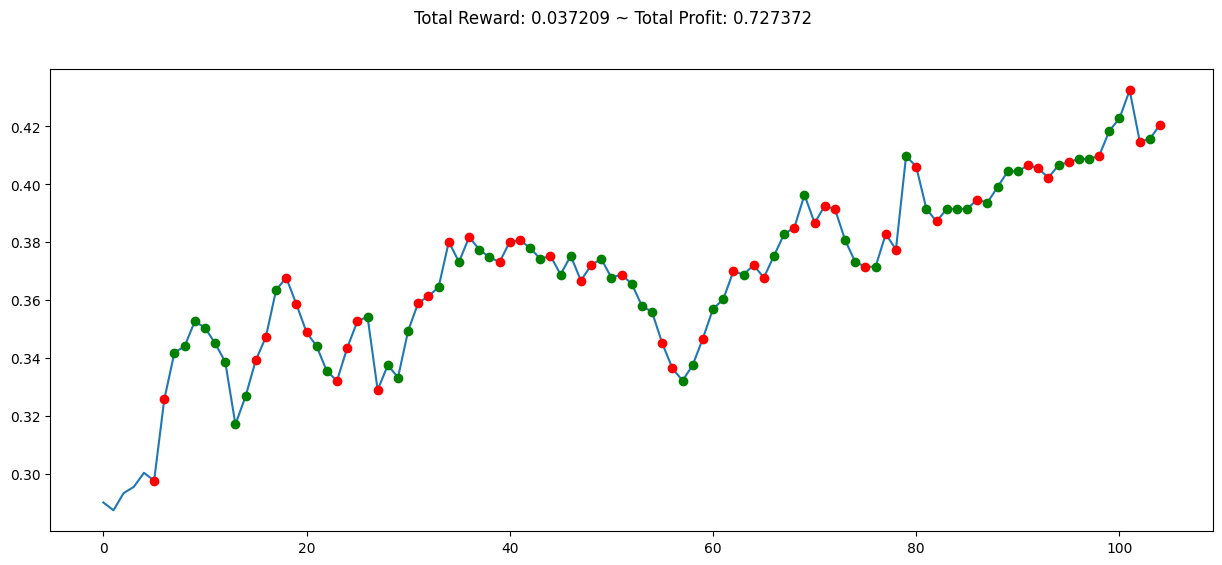

<Figure size 640x480 with 0 Axes>

In [7]:
bot_work('MSFT')

In [8]:
date,X,y = genreate_stock_data('GME','max')

In [9]:
X['Date']=date

In [10]:
X.set_index(['Date'],inplace=True)

In [11]:
X = X.iloc[::-1]

In [12]:
env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 2)
  logger.warn(
/home/om/.local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [13]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/om/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 668      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.681   |
|    explained_variance | 0.154    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0435  |
|    value_loss         | 0.00842  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 654      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.0288  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.781   |
|    value_loss      

------------------------------------
| time/                 |          |
|    fps                | 562      |
|    iterations         | 1700     |
|    time_elapsed       | 15       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -0.437   |
|    explained_variance | -0.0833  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | -0.0965  |
|    value_loss         | 0.116    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 566      |
|    iterations         | 1800     |
|    time_elapsed       | 15       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -0.527   |
|    explained_variance | -0.0529  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | -0.353   |
|    value_loss         | 0.175    |
-

------------------------------------
| time/                 |          |
|    fps                | 597      |
|    iterations         | 3300     |
|    time_elapsed       | 27       |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -0.00626 |
|    explained_variance | 0.37     |
|    learning_rate      | 0.0007   |
|    n_updates          | 3299     |
|    policy_loss        | 0.00195  |
|    value_loss         | 5.28     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 600      |
|    iterations         | 3400     |
|    time_elapsed       | 28       |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -0.0983  |
|    explained_variance | 0.349    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3399     |
|    policy_loss        | 0.0289   |
|    value_loss         | 1.54     |
-

------------------------------------
| time/                 |          |
|    fps                | 613      |
|    iterations         | 4900     |
|    time_elapsed       | 39       |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -0.117   |
|    explained_variance | -0.0595  |
|    learning_rate      | 0.0007   |
|    n_updates          | 4899     |
|    policy_loss        | -0.00534 |
|    value_loss         | 0.3      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 614      |
|    iterations         | 5000     |
|    time_elapsed       | 40       |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -0.117   |
|    explained_variance | -0.0182  |
|    learning_rate      | 0.0007   |
|    n_updates          | 4999     |
|    policy_loss        | -0.0192  |
|    value_loss         | 0.46     |
-

------------------------------------
| time/                 |          |
|    fps                | 634      |
|    iterations         | 6500     |
|    time_elapsed       | 51       |
|    total_timesteps    | 32500    |
| train/                |          |
|    entropy_loss       | -0.256   |
|    explained_variance | -0.45    |
|    learning_rate      | 0.0007   |
|    n_updates          | 6499     |
|    policy_loss        | -0.0869  |
|    value_loss         | 0.433    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 635      |
|    iterations         | 6600     |
|    time_elapsed       | 51       |
|    total_timesteps    | 33000    |
| train/                |          |
|    entropy_loss       | -0.00208 |
|    explained_variance | 0.0118   |
|    learning_rate      | 0.0007   |
|    n_updates          | 6599     |
|    policy_loss        | -0.0019  |
|    value_loss         | 44.9     |
-

------------------------------------
| time/                 |          |
|    fps                | 648      |
|    iterations         | 8100     |
|    time_elapsed       | 62       |
|    total_timesteps    | 40500    |
| train/                |          |
|    entropy_loss       | -0.235   |
|    explained_variance | -5.38    |
|    learning_rate      | 0.0007   |
|    n_updates          | 8099     |
|    policy_loss        | 0.007    |
|    value_loss         | 0.000147 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 648      |
|    iterations         | 8200     |
|    time_elapsed       | 63       |
|    total_timesteps    | 41000    |
| train/                |          |
|    entropy_loss       | -0.141   |
|    explained_variance | 0.00131  |
|    learning_rate      | 0.0007   |
|    n_updates          | 8199     |
|    policy_loss        | 0.00491  |
|    value_loss         | 0.579    |
-

-------------------------------------
| time/                 |           |
|    fps                | 649       |
|    iterations         | 9700      |
|    time_elapsed       | 74        |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -0.0117   |
|    explained_variance | -6.7      |
|    learning_rate      | 0.0007    |
|    n_updates          | 9699      |
|    policy_loss        | -0.000526 |
|    value_loss         | 0.323     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 649      |
|    iterations         | 9800     |
|    time_elapsed       | 75       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -0.0762  |
|    explained_variance | 0.1      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 0.0113   |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 649      |
|    iterations         | 11300    |
|    time_elapsed       | 86       |
|    total_timesteps    | 56500    |
| train/                |          |
|    entropy_loss       | -0.0371  |
|    explained_variance | 0.0783   |
|    learning_rate      | 0.0007   |
|    n_updates          | 11299    |
|    policy_loss        | -0.0489  |
|    value_loss         | 22.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 650      |
|    iterations         | 11400    |
|    time_elapsed       | 87       |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -0.0163  |
|    explained_variance | -17.6    |
|    learning_rate      | 0.0007   |
|    n_updates          | 11399    |
|    policy_loss        | -0.00103 |
|    value_loss         | 0.0554   |
-

------------------------------------
| time/                 |          |
|    fps                | 655      |
|    iterations         | 12900    |
|    time_elapsed       | 98       |
|    total_timesteps    | 64500    |
| train/                |          |
|    entropy_loss       | -0.0596  |
|    explained_variance | -0.124   |
|    learning_rate      | 0.0007   |
|    n_updates          | 12899    |
|    policy_loss        | 0.0136   |
|    value_loss         | 0.517    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 656      |
|    iterations         | 13000    |
|    time_elapsed       | 99       |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -0.103   |
|    explained_variance | -0.103   |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | 0.0407   |
|    value_loss         | 0.5      |
-

-------------------------------------
| time/                 |           |
|    fps                | 661       |
|    iterations         | 14500     |
|    time_elapsed       | 109       |
|    total_timesteps    | 72500     |
| train/                |           |
|    entropy_loss       | -0.000184 |
|    explained_variance | 0.137     |
|    learning_rate      | 0.0007    |
|    n_updates          | 14499     |
|    policy_loss        | 3.56e-06  |
|    value_loss         | 0.0542    |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 660      |
|    iterations         | 14600    |
|    time_elapsed       | 110      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -0.128   |
|    explained_variance | 0.889    |
|    learning_rate      | 0.0007   |
|    n_updates          | 14599    |
|    policy_loss        | 0.00257  |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 660      |
|    iterations         | 16100    |
|    time_elapsed       | 121      |
|    total_timesteps    | 80500    |
| train/                |          |
|    entropy_loss       | -0.144   |
|    explained_variance | 0.675    |
|    learning_rate      | 0.0007   |
|    n_updates          | 16099    |
|    policy_loss        | -0.13    |
|    value_loss         | 2.11     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 660       |
|    iterations         | 16200     |
|    time_elapsed       | 122       |
|    total_timesteps    | 81000     |
| train/                |           |
|    entropy_loss       | -0.000355 |
|    explained_variance | -0.723    |
|    learning_rate      | 0.0007    |
|    n_updates          | 16199     |
|    policy_loss        | -4.92e-06 |
|    value_loss         | 

------------------------------------
| time/                 |          |
|    fps                | 657      |
|    iterations         | 17700    |
|    time_elapsed       | 134      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -0.0592  |
|    explained_variance | 0.0902   |
|    learning_rate      | 0.0007   |
|    n_updates          | 17699    |
|    policy_loss        | 0.016    |
|    value_loss         | 0.667    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 657      |
|    iterations         | 17800    |
|    time_elapsed       | 135      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -0.0464  |
|    explained_variance | -0.997   |
|    learning_rate      | 0.0007   |
|    n_updates          | 17799    |
|    policy_loss        | -0.00681 |
|    value_loss         | 0.453    |
-

------------------------------------
| time/                 |          |
|    fps                | 659      |
|    iterations         | 19300    |
|    time_elapsed       | 146      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -0.0929  |
|    explained_variance | -0.495   |
|    learning_rate      | 0.0007   |
|    n_updates          | 19299    |
|    policy_loss        | -0.0281  |
|    value_loss         | 1.35     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 660       |
|    iterations         | 19400     |
|    time_elapsed       | 146       |
|    total_timesteps    | 97000     |
| train/                |           |
|    entropy_loss       | -0.00497  |
|    explained_variance | 0.422     |
|    learning_rate      | 0.0007    |
|    n_updates          | 19399     |
|    policy_loss        | -5.19e-05 |
|    value_loss         | 

In [14]:
env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.3424999713897705, 'total_profit': 0.7861780678937531, 'position': 1}
